In [1]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 5.0MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
!pip install --upgrade tensorflow==1.15.0

Requirement already up-to-date: tensorflow==1.15.0 in /usr/local/lib/python3.7/dist-packages (1.15.0)


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [5]:
y_train.shape

(60000,)

In [6]:
X_train.shape[1]

784

In [10]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# データフレームから条件抽出
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

# y = y.astype(np.int64)[:, np.newaxis]
# trainとtestに分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    tf.random.set_random_seed(0)
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    total_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        total_loss_list.append(total_loss)
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        val_loss_list.append(val_loss)
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

1.0
0.0
(60000,)
(60000, 10)
float64
Epoch 0, loss : 0.4406, val_loss : 0.9549, acc : 0.952
Epoch 1, loss : 0.0538, val_loss : 0.3048, acc : 0.955
Epoch 2, loss : 0.0195, val_loss : 0.1594, acc : 0.961
Epoch 3, loss : 0.0119, val_loss : 0.1208, acc : 0.969
Epoch 4, loss : 0.0091, val_loss : 0.1011, acc : 0.975
Epoch 5, loss : 0.0076, val_loss : 0.0927, acc : 0.977
Epoch 6, loss : 0.0066, val_loss : 0.0869, acc : 0.979
Epoch 7, loss : 0.0059, val_loss : 0.0813, acc : 0.980
Epoch 8, loss : 0.0053, val_loss : 0.0769, acc : 0.981
Epoch 9, loss : 0.0049, val_loss : 0.0757, acc : 0.982
test_acc : 0.982


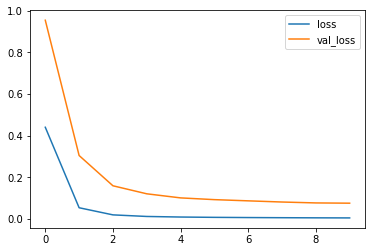

In [11]:
import matplotlib.pyplot as plt
plt.plot(total_loss_list, label='loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()
plt.show()